In [1]:
!pip install ultralytics opencv-python numpy torch torchvision
!pip install roboflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 43.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 45.8 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [2]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
from torchvision.io import read_image

# import matplotlib.pyplot as plt
from torchvision import models
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import os
import matplotlib.pyplot as plt

# Leaf classification: efficient net

In [4]:
!mkdir /root/.config/kaggle/
!mv kaggle.json /root/.config/kaggle/

!kaggle datasets download vipoooool/new-plant-diseases-dataset

!unzip new-plant-diseases-dataset.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/273a7a9e-18be-4b6a-976a-fa5ffd69b731___RS_HL 4366_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_90deg.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/275f8963-f4f4-4903-962b-1da716725d08___RS_HL 4780_new30degFlipLR.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665.JPG  
  inflating: new plant diseases dataset(augmented)/New Plant Diseases Dataset(Augmented)/valid/Strawberry___healthy/27c2aaa4-de4b-4fb1-ba8d-14d4b24b2afa___RS_HL 4665_270deg.JPG  
  inflating: new plant diseases datase

In [6]:
dataset_path = "New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"

train_dir = os.path.join(dataset_path, 'train')
valid_dir = os.path.join(dataset_path, 'valid')

class_folders = [f for f in os.listdir(train_dir)]
distribution = []
class_names = []

for class_name in sorted(class_folders):
    class_path = os.path.join(train_dir, class_name)


    distribution.append(len(os.listdir(class_path)))
    class_names.append(class_name)



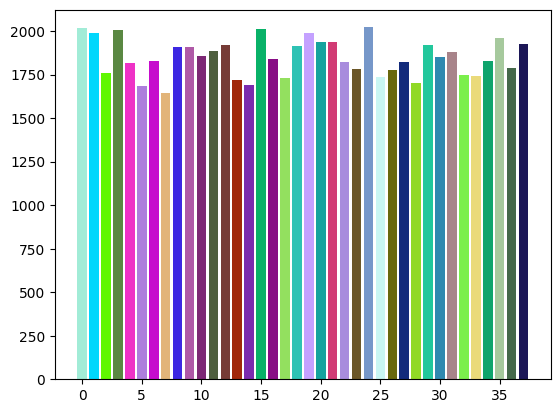

In [7]:
def generate_rgb_colors(n):
    """Generate n random RGB colors"""
    return np.random.rand(n, 3)

num_classes = len(distribution)
colors = generate_rgb_colors(num_classes)
plt.plot()
plt.bar(list(range(num_classes)), distribution, color=colors)
plt.show()

In [42]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(train_dir, transform=train_transform)
gen_dataset = datasets.ImageFolder(valid_dir, transform=val_transform)

targets = [sample[1] for sample in gen_dataset]

val_indices, test_indices = train_test_split(
    range(len(gen_dataset)),
    test_size=0.5,
    stratify=targets,
    random_state=42
)

val_dataset = Subset(gen_dataset, val_indices)
test_dataset = Subset(gen_dataset, test_indices)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training classes: {train_dataset.classes}")
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")

Training classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', '

### Create mini-dataset

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

random_state = 42

train_labels = [label for _, label in train_dataset.samples]
train_indices = list(range(len(train_dataset)))

val_labels = [label for _, label in val_dataset.samples]
val_indices = list(range(len(val_dataset)))

small_train_idx, _ = train_test_split(
        train_indices,
        train_size=batch_size * 10,
        stratify=train_labels,
        random_state=random_state
)

small_val_idx, extra_idx = train_test_split(
        val_indices,
        train_size=batch_size * 10,
        stratify=val_labels,
        random_state=random_state
)

small_train = Subset(train_dataset, small_train_idx)
small_val = Subset(val_dataset, small_val_idx)
small_test = Subset(val_dataset, np.random.choice(extra_idx, batch_size * 5, replace=False))

small_train_loader = DataLoader(small_train, batch_size=batch_size, shuffle=True)
small_val_loader = DataLoader(small_val, batch_size=batch_size, shuffle=False)
small_test_loader = DataLoader(small_test, batch_size=batch_size, shuffle=False)

### Train model

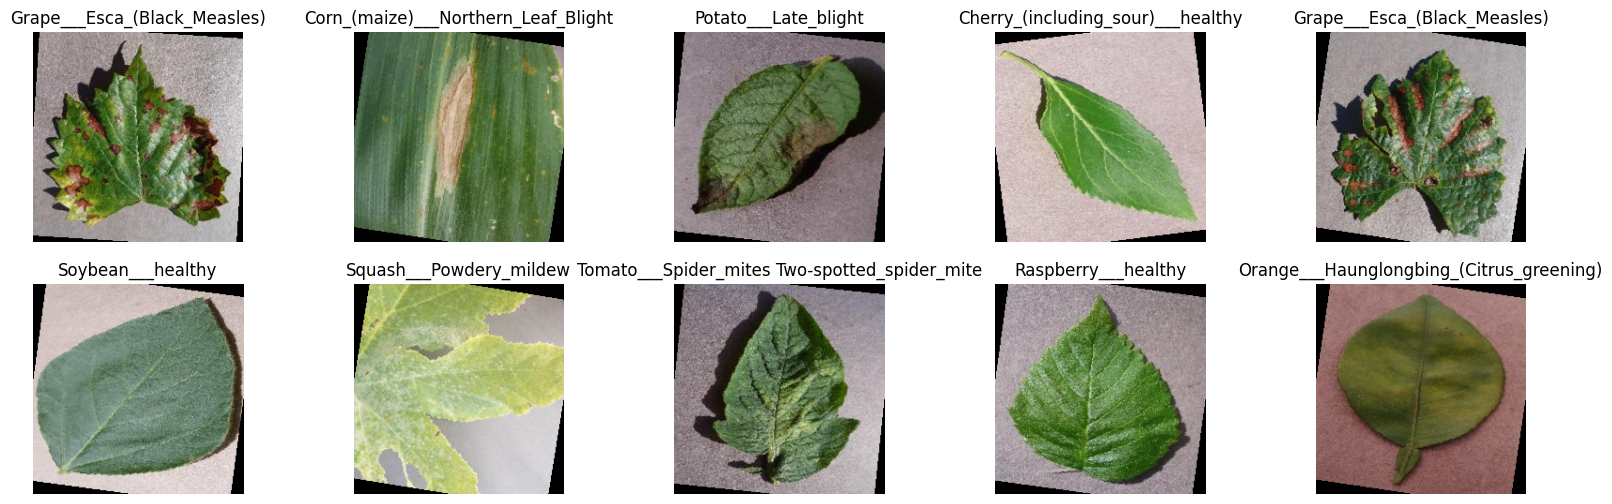

In [9]:
def plot_images(images, labels, classes, rows=2, columns=5):
    """
    Plots images with captions

    :param images: list of images to plot
    :param captions: captions of images:
    :param rows: number of rows in figure
    :param columns: number of columns:
    :param title: super title of figure
    """
    fig = plt.figure(figsize=(20, 6))
    for i, img in enumerate(images):
        img = img.numpy().transpose((1, 2, 0))
        fig.add_subplot(rows, columns, i + 1)
        plt.imshow(img)
        if i < len(labels):
            plt.title(classes[labels[i]])
        plt.axis("off")
    plt.show()


images, labels = next(iter(train_loader))
plot_images(images[:10], labels, train_dataset.classes)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.efficientnet_b3(pretrained=True)

num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B3_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth


100%|██████████| 47.2M/47.2M [00:00<00:00, 184MB/s]


In [11]:
from tqdm.notebook import tqdm

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=7, gamma=0.1)

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=20):
    best_acc = 0.0
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        model.train()
        running_loss = 0.0
        running_corrects = 0

        for data in tqdm(train_loader, desc='Training'):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        total_number = len(train_loader.dataset)
        epoch_loss = running_loss / total_number
        epoch_acc = running_corrects.item() / total_number
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc)

        model.eval()
        val_loss = 0.0
        val_corrects = 0

        with torch.no_grad():
            for data in tqdm(val_loader, desc='Validation'):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                _, preds = torch.max(outputs, 1)

                val_loss += loss.item() * inputs.size(0)
                val_corrects += torch.sum(preds == labels.data)

        total_number = len(val_loader.dataset)
        val_epoch_loss = val_loss / total_number
        val_epoch_acc = val_corrects.item() / total_number
        history['val_loss'].append(val_epoch_loss)
        history['val_acc'].append(val_epoch_acc)

        print(f'Train Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_epoch_loss:.4f} Acc: {val_epoch_acc:.4f}')

        if val_epoch_acc > best_acc:
            best_acc = val_epoch_acc
            torch.save(model.state_dict(), 'best_efficientnet_model.pth')

        scheduler.step()
        print()

    return history, model

In [12]:
history, trained_model = train_model(
    model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=10
)

Epoch 1/10
----------


Training:   0%|          | 0/2197 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
test_loss_accum = 0.0
test_corrects_accum = 0

model = models.efficientnet_b3(pretrained=False)
num_classes = len(train_dataset.classes)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Load your saved weights
model.load_state_dict(torch.load('best_efficientnet_model.pth'))

model = model.to(device)

model.eval()

with torch.no_grad():
  for data in tqdm(test_loader, desc='Test'):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)

      outputs = model(inputs)
      loss = criterion(outputs, labels)
      _, preds = torch.max(outputs, 1)

      test_loss_accum += loss.item() * inputs.size(0)
      test_corrects_accum += torch.sum(preds == labels.data)

total_number = len(test_loader.dataset)
test_loss = test_loss_accum / total_number
test_acc = test_corrects_accum / total_number

print(f'Test Loss: {test_loss:.4f} Acc: {test_acc:.4f}')
print(f'{test_corrects_accum} / {total_number}')

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
Test: 100%|██████████| 275/275 [00:41<00:00,  6.55it/s]

Test Loss: 0.0056 Acc: 0.9989
8776 / 8786


In [43]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def generate_classification_report(model, test_loader, class_names, device):
    """
    Generate comprehensive classification report
    """
    model.eval()
    all_predictions = []
    all_labels = []
    all_probabilities = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predictions = torch.max(outputs, 1)

            all_predictions.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_labels = np.array(all_labels)
    all_probabilities = np.array(all_probabilities)

    report = classification_report(all_labels, all_predictions,
                                 target_names=class_names, output_dict=True)

    return report, all_predictions, all_labels, all_probabilities

class_names = gen_dataset.classes

report, predictions, true_labels, probabilities = generate_classification_report(
    model, test_loader, class_names, device
)


print("Classification Report:")
print(classification_report(true_labels, predictions, target_names=class_names))

Classification Report:
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      1.00      1.00       252
                                 Apple___Black_rot       1.00      1.00      1.00       248
                          Apple___Cedar_apple_rust       1.00      1.00      1.00       220
                                   Apple___healthy       1.00      1.00      1.00       251
                               Blueberry___healthy       1.00      1.00      1.00       227
          Cherry_(including_sour)___Powdery_mildew       1.00      1.00      1.00       210
                 Cherry_(including_sour)___healthy       1.00      1.00      1.00       228
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       1.00      0.99      0.99       205
                       Corn_(maize)___Common_rust_       1.00      1.00      1.00       239
               Corn_(maize)___Northern_Leaf_Blight      

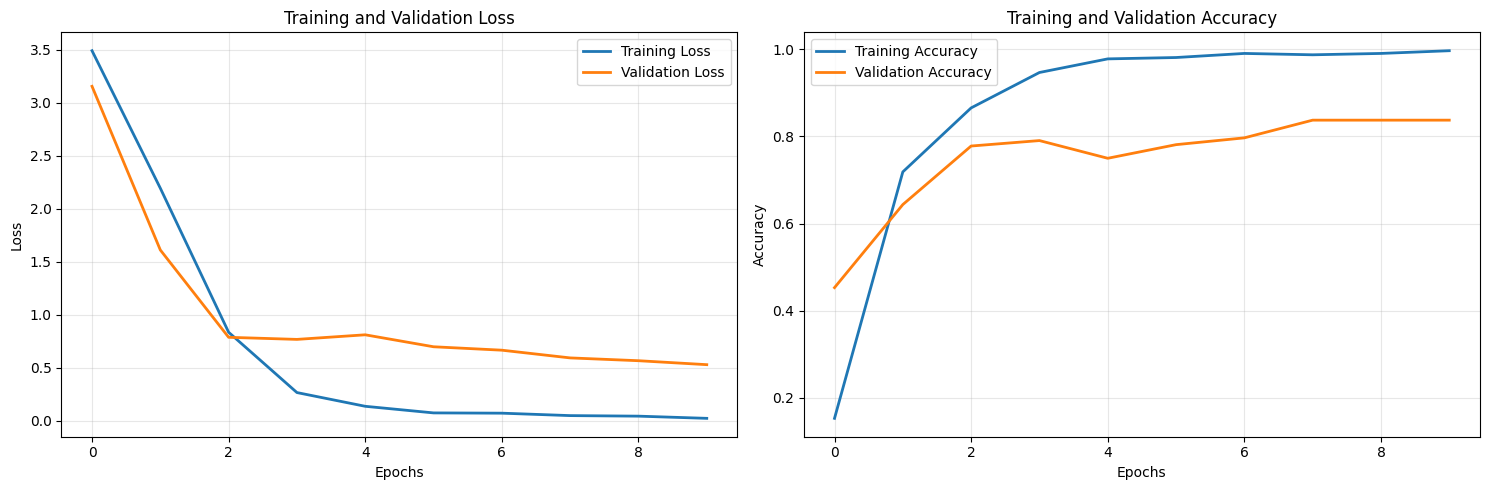

In [ ]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    """
    Plot training and validation loss and accuracy
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot loss
    ax1.plot(history['train_loss'], label='Training Loss', linewidth=2)
    ax1.plot(history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot accuracy
    ax2.plot(history['train_acc'], label='Training Accuracy', linewidth=2)
    ax2.plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Usage
plot_training_history(history)

In [ ]:
import torch
from PIL import Image
import torch.nn.functional as F

def predict_image(image_path, model, transform, class_names, device):
    """
    Predict class for a single image
    """
    image = Image.open(image_path).convert('RGB')

    input_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    input_tensor = input_tensor.to(device)

    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = F.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)

    predicted_idx = predicted_class.item()
    predicted_name = class_names[predicted_idx]
    confidence_score = confidence.item()

    return predicted_name, confidence_score, predicted_idx

predicted_class, confidence, class_idx = predict_image(
    image_path="/content/test/test/TomatoHealthy1.JPG",
    model=model,
    transform=val_transform,
    class_names=train_dataset.classes,
    device=device
)

print(f"Predicted: {predicted_class} (confidence: {confidence:.4f})")

Predicted: Tomato___healthy (confidence: 0.9642)


# Leaf detection: YOLOv8

In [15]:
from ultralytics import YOLO
import os
from roboflow import Roboflow
import yaml

rf = Roboflow(api_key="p26BTo8mq00ZkzGoRw98")
project = rf.workspace("cropdataset").project("plant-doc-dgqyu")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...


### Create mini-dataset

In [ ]:
# import os
# import random
# import shutil

# # Paths
# base_dir = "plant-doc-1"
# train_images = os.path.join(base_dir, "train/images")
# train_labels = os.path.join(base_dir, "train/labels")

# mini_dir = os.path.join(base_dir, "train_mini")
# mini_images = os.path.join(mini_dir, "images")
# mini_labels = os.path.join(mini_dir, "labels")

# os.makedirs(mini_images, exist_ok=True)
# os.makedirs(mini_labels, exist_ok=True)

# # Number of samples to keep
# num_samples = 200
# image_files = [f for f in os.listdir(train_images) if f.endswith((".jpg", ".png"))]
# sampled = random.sample(image_files, min(num_samples, len(image_files)))

# # Copy sampled images and labels
# for img_file in sampled:
#     label_file = os.path.splitext(img_file)[0] + ".txt"
#     shutil.copy(os.path.join(train_images, img_file), os.path.join(mini_images, img_file))
#     if os.path.exists(os.path.join(train_labels, label_file)):
#         shutil.copy(os.path.join(train_labels, label_file), os.path.join(mini_labels, label_file))

# print(f"✅ Mini dataset created with {len(sampled)} images at {mini_dir}")


✅ Mini dataset created with 50 images at plant-doc-1/train_mini


In [ ]:
# yaml_content = """
# names:
# - Apple Scab Leaf
# - Apple leaf
# - Apple rust leaf
# - Bell_pepper leaf
# - Bell_pepper leaf spot
# - Blueberry leaf
# - Cherry leaf
# - Corn Gray leaf spot
# - Corn leaf blight
# - Corn rust leaf
# - Peach leaf
# - Potato leaf
# - Potato leaf early blight
# - Potato leaf late blight
# - Raspberry leaf
# - Soyabean leaf
# - Soybean leaf
# - Squash Powdery mildew leaf
# - Strawberry leaf
# - Tomato Early blight leaf
# - Tomato Septoria leaf spot
# - Tomato leaf
# - Tomato leaf bacterial spot
# - Tomato leaf late blight
# - Tomato leaf mosaic virus
# - Tomato leaf yellow virus
# - Tomato mold leaf
# - Tomato two spotted spider mites leaf
# - grape leaf
# - grape leaf black rot
# nc: 30
# roboflow:
#   license: CC BY 4.0
#   project: plant-doc-dgqyu
#   url: https://universe.roboflow.com/cropdataset/plant-doc-dgqyu/dataset/1
#   version: 1
#   workspace: cropdataset
# test: ../test/images
# train: ../train_mini/images
# val: ../valid/images
# """

# with open('plant-doc-1/data-mini.yaml', 'w') as f:
#     f.write(yaml_content)

### Train model

In [ ]:
# Load a pretrained YOLOv8 model
model = YOLO("yolov8n.pt")  # or "yolov8n.pt", "yolov8s.pt", "yolov8l.pt", "yolov8x.pt"

model.train(
    data='plant-doc-1/data.yaml',
    epochs=60,
    imgsz=640,
    batch=16,
    device=0,
    workers=2
)

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=plant-doc-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretr

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ba25819fb90>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.0

In [ ]:
model = YOLO('runs/detect/train/weights/best.pt')

results = model.val(
    data='plant-doc-1/data.yaml',
    split='test'
)

print("Validation results:")
print(f"mAP50: {results.box.map50:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"Recall: {results.box.mr:.4f}")

Ultralytics 8.3.223 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,011,498 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1443.5±640.4 MB/s, size: 54.8 KB)
val: Scanning /content/plant-doc-1/test/labels... 128 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 2.2Kit/s 0.1s
val: New cache created: /content/plant-doc-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.2it/s 3.7s
                   all        128        486      0.447        0.5      0.529      0.391
       Apple Scab Leaf          5          9      0.181      0.222      0.185      0.142
            Apple leaf          5          6      0.304      0.667      0.721      0.596
       Apple rust leaf          5          8       0.28        0.5      0.278      0.194
      Bell_pepper leaf          5         18      0.755      0.722      0.759    

In [ ]:
!rm -rf runs/detect/predict*

In [ ]:
import glob
from IPython.display import Image, display

results = model.predict(
    source='plant-doc-1/test/images',
    save=True,
    conf=0.25,
    iou=0.45,
    project='runs/detect',
    name='predict'
);


image 1/128 /content/plant-doc-1/test/images/009-e1373768789869_jpg.rf.09acafe57a359a3ace4193c4e3bc0fe5.jpg: 640x640 1 Tomato leaf, 2 Tomato leaf mosaic viruss, 9.5ms
image 2/128 /content/plant-doc-1/test/images/06c_jpg.rf.e63db153b2fe6776ab2a8f5579e06b3c.jpg: 640x640 7 Corn leaf blights, 7.3ms
image 3/128 /content/plant-doc-1/test/images/10-3-bacterial-speck-on-tomato-RON_jpg.rf.00f502b49c16bf5a5ee5e48f6dd9b4ce.jpg: 640x640 1 Tomato Septoria leaf spot, 7.3ms
image 4/128 /content/plant-doc-1/test/images/100983448_jpg.rf.b14e2edd3a8c0d666ef5c2b98622c414.jpg: 640x640 1 Tomato Early blight leaf, 1 Tomato leaf bacterial spot, 7.3ms
image 5/128 /content/plant-doc-1/test/images/1058_0_jpeg-itok-OQkdtxgv_jpg.rf.22b6e2ff09151a5cc42f4ec42c38d59f.jpg: 640x640 1 Bell_pepper leaf spot, 7.3ms
image 6/128 /content/plant-doc-1/test/images/1737796_orig_jpg.rf.f02a230a5aab3f19b7b4bff9e4a00941.jpg: 640x640 1 Apple leaf, 2 Peach leafs, 7.3ms
image 7/128 /content/plant-doc-1/test/images/1846_400x400_4_jp

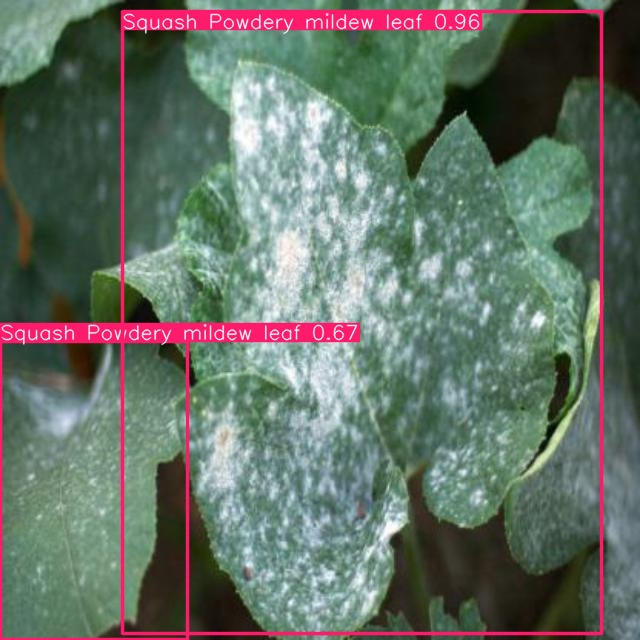

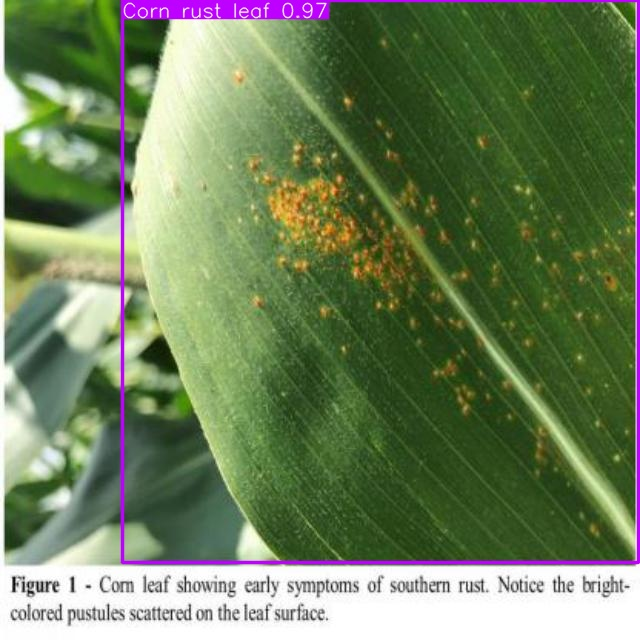

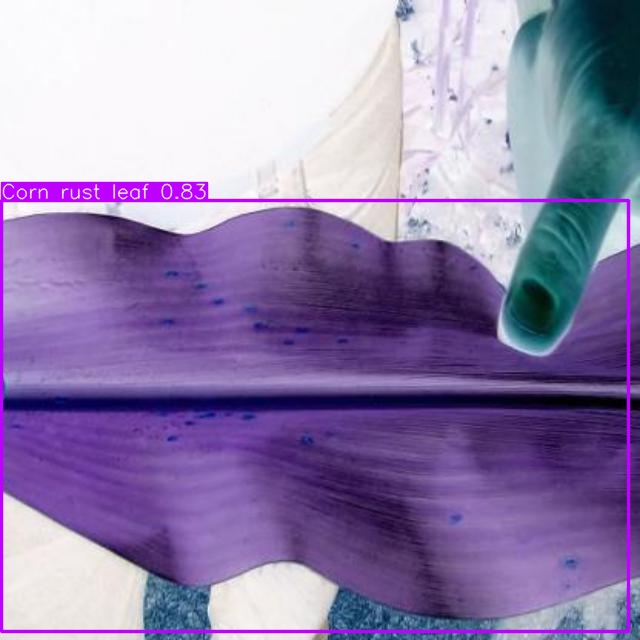

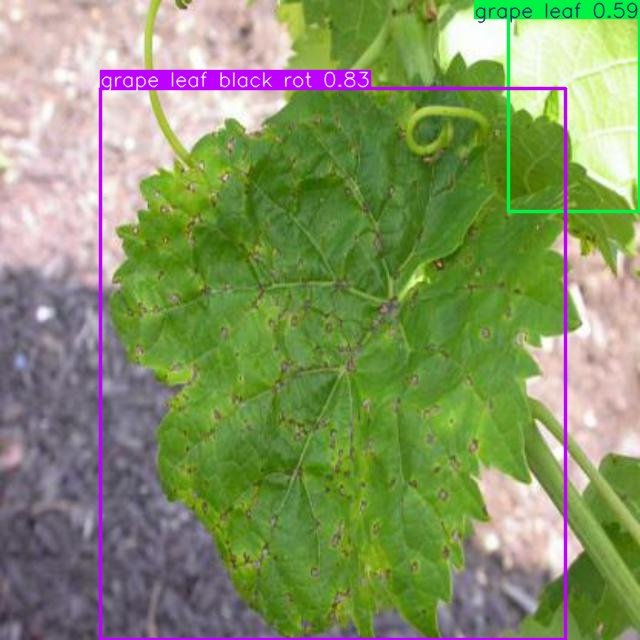

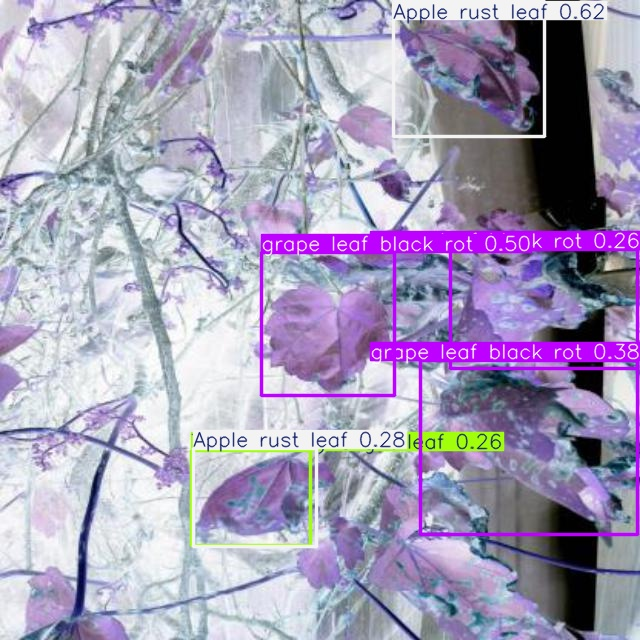

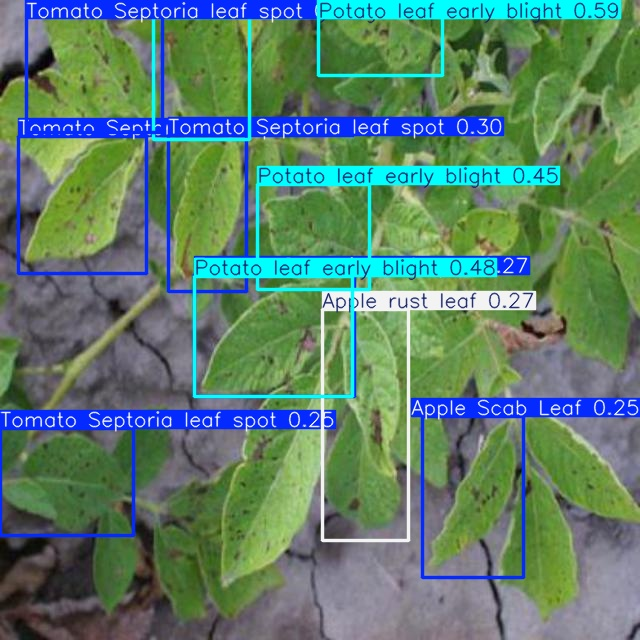

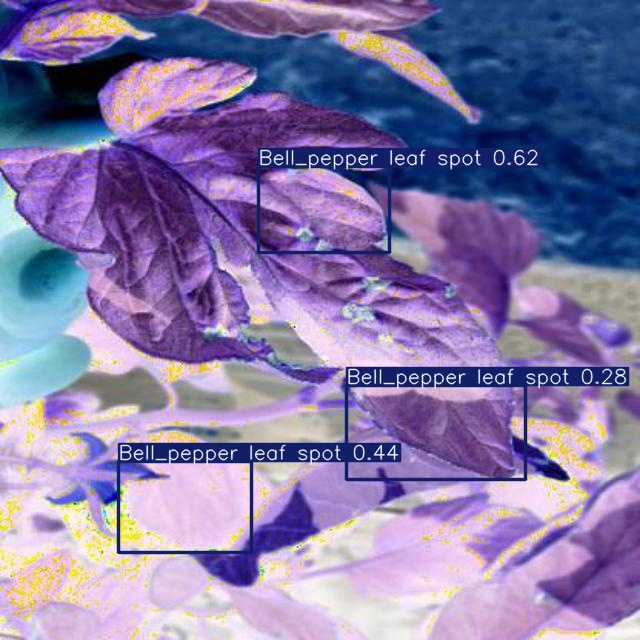

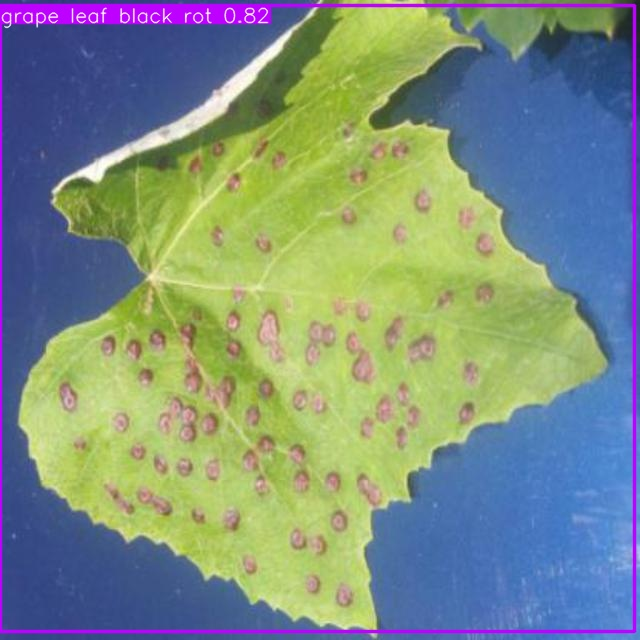

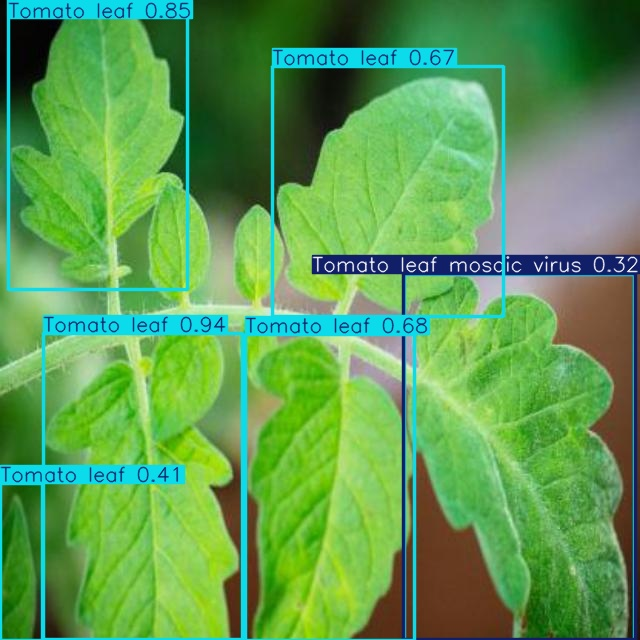

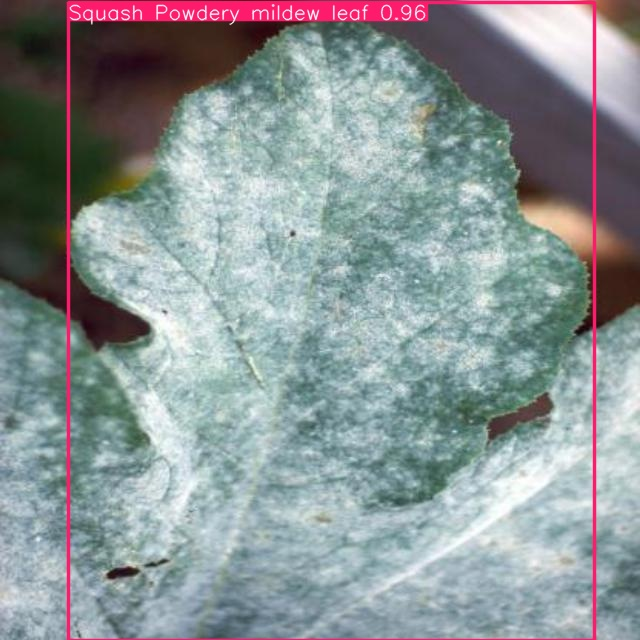

In [ ]:
# Display predicted images
for image_path in glob.glob('runs/detect/predict/*.jpg')[:10]:
    _ = display(Image(filename=image_path, height=400))
    # print('\n')

# Train YOLOv8 using augmentation

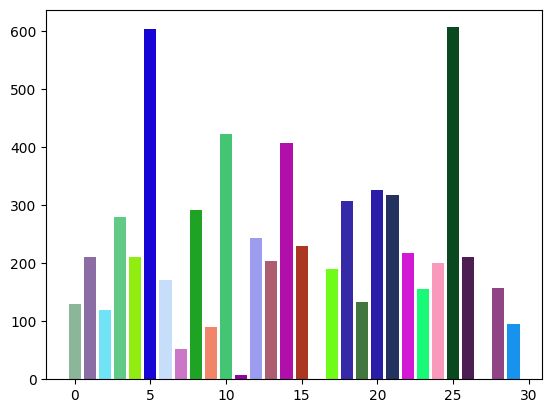

In [49]:
import matplotlib.pyplot as plt

def generate_rgb_colors(n):
    """Generate n random RGB colors"""
    return np.random.rand(n, 3)

labels_path = f"plant-doc-1/train/labels"
label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]

with open('plant-doc-1/data.yaml', 'r') as f:
  original_config = yaml.safe_load(f)
num_classes = original_config['nc']
distribution = [0 for _ in range(num_classes)]

for label_file in label_files:
    label_path = os.path.join(labels_path, label_file)
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if line.strip():
            class_id = int(line.split()[0])
            distribution[class_id] += 1

colors = generate_rgb_colors(num_classes)
plt.plot()
plt.bar(list(range(num_classes)), distribution, color=colors)
plt.show()

In [53]:
print("Number of leaves in train", np.sum(distribution))

Number of leaves in train 6590


In [17]:
model = YOLO('yolov8n.pt')
results = model.train(
    data='plant-doc-1/data.yaml',
    epochs=60,
    imgsz=640,

    # Strong augmentation for robustness
    augment=True,
    hsv_h=0.015,
    hsv_s=0.7,
    hsv_v=0.4,
    degrees=180.0,  # Full rotation for uniform learning
    translate=0.2,
    scale=0.5,
    fliplr=0.5,
    mosaic=1.0,
    mixup=0.1,

    # For imbalanced datasets
    cls=0.5,  # Class loss gain

    # Training optimization
    cos_lr=True,
    close_mosaic=10,
    patience=30,  # More patience for learning rare classes

    project='runs/detect',
    name='augmented'
)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=plant-doc-1/data.yaml, degrees=180.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=augmented, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=30, perspective=0.0, plots=True, pose=12.0,

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1606.5±529.9 MB/s, size: 46.4 KB)
train: Scanning /content/plant-doc-1/train/labels... 1926 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1926/1926 2.5Kit/s 0.8s
train: New cache created: /content/plant-doc-1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 607.2±257.2 MB/s, size: 44.2 KB)
val: Scanning /content/plant-doc-1/valid/labels... 513 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 513/513 1.5Kit/s 0.4s
val: New cache created: /content/plant-doc-1/valid/labels.cache
Plotting labels to /content/runs/detect/augmented/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automat

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       1/60      5.83G      1.968      4.471      2.213         35        640: 100% ━━━━━━━━━━━━ 121/121 3.1it/s 38.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.8it/s 6.0s
                   all        513       1731      0.014      0.337     0.0276     0.0117

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/60      5.83G      1.538      4.252      1.891        105        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       2/60      5.84G      1.647      4.011      1.945         24        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 32.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.1it/s 5.5s
                   all        513       1731      0.308      0.156     0.0491     0.0216

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/60      5.86G      1.458      3.814      1.896        117        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       3/60      5.86G      1.643       3.71       1.97         39        640: 100% ━━━━━━━━━━━━ 121/121 3.4it/s 36.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.1it/s 5.5s
                   all        513       1731      0.159      0.146     0.0762     0.0348

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/60      5.87G      1.719      3.748      2.058         69        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       4/60      5.88G       1.63      3.498      1.923         24        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.4it/s 5.0s
                   all        513       1731      0.206      0.234     0.0968     0.0432

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/60      5.89G      1.527      3.633      1.843         83        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       5/60      5.89G      1.584       3.37      1.907         57        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.0it/s 5.7s
                   all        513       1731      0.214      0.203      0.129     0.0626

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/60       5.9G      1.537      3.362      1.904         99        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       6/60      5.92G      1.563      3.236      1.873         35        640: 100% ━━━━━━━━━━━━ 121/121 3.1it/s 39.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.154      0.218      0.127     0.0602

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/60      5.93G      1.326      3.074      1.759         86        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       7/60      5.93G      1.546      3.185      1.871         39        640: 100% ━━━━━━━━━━━━ 121/121 3.3it/s 37.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.2it/s 5.2s
                   all        513       1731      0.184      0.259      0.156     0.0758

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/60      5.95G      1.472      3.251        1.9        112        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       8/60      5.95G      1.517      3.081      1.843         37        640: 100% ━━━━━━━━━━━━ 121/121 3.4it/s 35.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.7it/s 6.4s
                   all        513       1731      0.214      0.273       0.19      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/60      5.96G      1.581      2.944      1.902        114        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       9/60      5.96G      1.506      2.988      1.825         47        640: 100% ━━━━━━━━━━━━ 121/121 3.2it/s 38.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.5it/s 4.8s
                   all        513       1731      0.178      0.314      0.215      0.107

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/60      5.97G        1.3      2.739      1.714        103        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      10/60      5.98G      1.496      2.963      1.813         45        640: 100% ━━━━━━━━━━━━ 121/121 3.3it/s 37.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.203      0.288      0.194      0.109

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/60         6G      1.262      2.875      1.711         76        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      11/60         6G      1.495      2.902      1.807         51        640: 100% ━━━━━━━━━━━━ 121/121 3.3it/s 37.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.4it/s 5.0s
                   all        513       1731      0.206      0.334      0.232      0.125

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/60      6.01G      1.583      3.174      1.912        118        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      12/60      6.02G      1.488      2.873      1.801         42        640: 100% ━━━━━━━━━━━━ 121/121 3.4it/s 36.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.8it/s 6.2s
                   all        513       1731      0.317      0.257      0.232       0.14

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/60      6.03G      1.499      2.801      1.707        134        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      13/60      6.03G      1.478      2.829      1.791         55        640: 100% ━━━━━━━━━━━━ 121/121 3.0it/s 40.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.8s
                   all        513       1731      0.249      0.318      0.228      0.135

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/60      6.04G      1.493      2.874      1.862        100        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      14/60      6.05G      1.494      2.827      1.808         59        640: 100% ━━━━━━━━━━━━ 121/121 3.0it/s 40.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.6it/s 6.5s
                   all        513       1731      0.263      0.348       0.26      0.138

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/60      6.07G      1.662      2.999      1.947        133        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      15/60      6.07G      1.487      2.755      1.792         34        640: 100% ━━━━━━━━━━━━ 121/121 3.1it/s 38.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.5it/s 4.9s
                   all        513       1731      0.274      0.354      0.255       0.15

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/60      6.08G       1.45      2.567      1.634        125        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      16/60      6.08G      1.477      2.768      1.783         53        640: 100% ━━━━━━━━━━━━ 121/121 3.2it/s 38.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.4it/s 5.0s
                   all        513       1731       0.29      0.344      0.275      0.155

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/60       6.1G      1.554      2.563      1.712        172        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      17/60       6.1G      1.456      2.691      1.757         44        640: 100% ━━━━━━━━━━━━ 121/121 3.2it/s 38.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.0it/s 5.7s
                   all        513       1731      0.264      0.397      0.283      0.167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/60      6.11G       1.57      3.056      1.785        156        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      18/60      6.12G      1.461      2.657      1.755         32        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.0it/s 5.7s
                   all        513       1731      0.294      0.325      0.276      0.158

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/60      6.13G      1.433      2.577      1.856        128        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      19/60      6.13G      1.454      2.687      1.753         27        640: 100% ━━━━━━━━━━━━ 121/121 3.4it/s 35.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.2s
                   all        513       1731      0.273      0.404      0.305      0.181

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/60      6.15G      1.432      2.764      1.726        114        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      20/60      6.15G      1.441      2.616      1.747         41        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.1s
                   all        513       1731      0.294      0.361      0.304       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/60      6.17G      1.485       2.51      1.757        107        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      21/60      6.17G      1.418      2.564       1.72         52        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 35.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.325      0.372      0.325      0.189

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/60      6.17G      1.485      2.908      1.799         83        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      22/60      6.19G      1.426      2.579      1.733         25        640: 100% ━━━━━━━━━━━━ 121/121 3.4it/s 35.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.5it/s 4.9s
                   all        513       1731      0.272      0.358      0.286      0.168

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/60       6.2G      1.379      2.289      1.704        132        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      23/60       6.2G      1.426      2.547      1.735         41        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731       0.28        0.4      0.311       0.19

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/60      6.21G       1.52      2.709      1.724        132        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      24/60      6.22G      1.433      2.542      1.736         33        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.3s
                   all        513       1731       0.35       0.36      0.328      0.201

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/60      6.23G      1.533      2.682      1.778        156        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      25/60      6.24G      1.405      2.505      1.718         32        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731      0.356       0.35      0.324      0.199

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/60      6.24G      1.387      2.316      1.671        118        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      26/60      6.25G      1.415       2.49       1.73         58        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.4s
                   all        513       1731      0.365      0.359      0.321      0.202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/60      6.27G      1.443      2.597      1.626        140        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      27/60      6.27G      1.407      2.455      1.716         50        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.4s
                   all        513       1731      0.377      0.346      0.338      0.209

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/60      6.29G      1.574      2.588       1.75        151        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      28/60      6.29G      1.389      2.425      1.706         60        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731      0.318      0.422      0.349      0.198

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/60       6.3G      1.305      2.154      1.659        123        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      29/60      6.31G      1.413      2.443      1.708         45        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.345      0.383      0.341       0.21

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/60      6.31G      1.422      2.525      1.682         96        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      30/60      6.32G      1.411      2.452      1.717         40        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731       0.34      0.409      0.357      0.224

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/60      6.34G      1.236      2.279      1.616         92        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      31/60      6.35G      1.375      2.359      1.687         41        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.3s
                   all        513       1731      0.338      0.407      0.362      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/60      6.35G      1.266      2.368      1.652        110        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      32/60      6.36G       1.37      2.357       1.68         38        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.3s
                   all        513       1731      0.338      0.404      0.336      0.195

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/60      6.37G      1.481      2.574      1.675        150        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      33/60      6.38G      1.381      2.374      1.694         33        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.5s
                   all        513       1731      0.357      0.378      0.357       0.22

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/60      6.38G      1.458      2.394      1.793        143        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      34/60       6.4G      1.393      2.366      1.693         75        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.2s
                   all        513       1731      0.399      0.374      0.364      0.228

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/60       6.4G      1.338       2.42      1.667         83        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      35/60      6.41G      1.375      2.301      1.671         33        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.5s
                   all        513       1731      0.325      0.433      0.367      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/60      6.42G      1.259      2.224      1.573        117        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      36/60      6.43G      1.386      2.305      1.679         38        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.422       0.41       0.38      0.244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/60      6.44G      1.389      2.003      1.728        114        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      37/60      6.44G      1.364      2.281      1.676         44        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731      0.386       0.43      0.379      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/60      6.45G      1.538      2.611      1.784        115        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      38/60      6.46G      1.361      2.279      1.678         33        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 35.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.2s
                   all        513       1731      0.356      0.427      0.392       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/60      6.47G      1.189      2.317       1.63         84        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      39/60      6.48G      1.361      2.271      1.676         56        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.5s
                   all        513       1731      0.392      0.422      0.385       0.25

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/60      6.49G      1.183      2.046      1.564         94        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      40/60      6.49G      1.348      2.235      1.667         44        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731      0.408      0.418      0.394      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/60      6.51G      1.287        2.1      1.626        119        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      41/60      6.51G      1.356      2.252      1.664         29        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.3s
                   all        513       1731      0.381      0.437      0.394      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/60      6.51G      1.214      2.074      1.564        107        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      42/60      6.53G      1.358      2.248      1.679         35        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731      0.385      0.429      0.398      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/60      6.54G      1.318      2.327      1.624        111        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      43/60      6.54G      1.349      2.237      1.663         49        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 34.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.5it/s 4.8s
                   all        513       1731      0.403      0.443      0.398      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/60      6.56G      1.365      2.166      1.582        121        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      44/60      6.56G      1.334      2.181      1.649         59        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 34.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.3s
                   all        513       1731      0.396       0.47      0.404      0.263

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/60      6.58G      1.358      2.273      1.682        146        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      45/60      6.58G       1.33      2.193      1.641         63        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.4s
                   all        513       1731      0.379      0.453      0.389      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/60      6.58G      1.221      2.278      1.615         82        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      46/60       6.6G      1.335      2.198      1.651         42        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.411      0.448      0.406      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/60      6.61G      1.358       2.26      1.649         96        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      47/60      6.61G      1.346      2.194      1.653         48        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.5it/s 4.8s
                   all        513       1731      0.426      0.447       0.41       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/60      6.63G      1.388          2      1.641        113        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      48/60      6.63G      1.334      2.178      1.646         77        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.403      0.468      0.406      0.265

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      49/60      6.65G      1.336      2.156      1.637         42        640: 100% ━━━━━━━━━━━━ 121/121 3.5it/s 34.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731      0.408      0.432      0.408      0.268

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/60      6.65G      1.546      2.392      1.801        146        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      50/60      6.67G      1.323      2.151      1.636         42        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.1s
                   all        513       1731      0.415      0.448      0.411      0.268
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      51/60      6.68G      1.324      1.981      1.709         61        640: 0% ──────────── 0/121  0.9s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      51/60      6.68G      1.185      2.008      1.564         14        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 32.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731      0.401      0.434      0.403      0.264

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      52/60      6.69G      1.531        2.2      1.478         96        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      52/60       6.7G      1.158      1.918      1.556         19        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.2s
                   all        513       1731      0.385      0.431      0.408      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      53/60      6.71G      1.012      1.961      1.459         51        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      53/60      6.72G      1.152       1.87      1.541         11        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.3s
                   all        513       1731      0.439      0.415      0.406      0.269

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      54/60      6.72G      1.151       1.73       1.43         55        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      54/60      6.73G      1.167      1.887      1.546         33        640: 100% ━━━━━━━━━━━━ 121/121 4.1it/s 29.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.2it/s 5.3s
                   all        513       1731      0.416      0.433      0.401      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      55/60      6.74G     0.9966      1.784      1.398         32        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      55/60      6.75G      1.146      1.855      1.533         17        640: 100% ━━━━━━━━━━━━ 121/121 4.0it/s 30.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.2s
                   all        513       1731       0.42      0.429      0.404       0.27

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      56/60      6.77G      1.014       1.99      1.572         37        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      56/60      6.77G      1.153      1.839      1.542         17        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.1s
                   all        513       1731      0.427       0.43      0.411      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      57/60      6.78G      1.173      1.636      1.387         79        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      57/60      6.79G      1.142      1.824      1.538         15        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.424      0.432      0.409      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      58/60      6.79G     0.9308      1.806      1.362         42        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      58/60       6.8G      1.149      1.824      1.526         18        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.2s
                   all        513       1731      0.428      0.427      0.409      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      59/60      6.81G      1.224      1.873      1.476         53        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      59/60      6.82G      1.157      1.837      1.535         36        640: 100% ━━━━━━━━━━━━ 121/121 4.0it/s 30.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.1s
                   all        513       1731      0.427      0.438      0.407      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      60/60      6.83G      1.221      2.077      1.592         40        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      60/60      6.83G      1.139      1.831      1.535         29        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.1s
                   all        513       1731      0.418      0.439      0.405       0.27

60 epochs completed in 0.664 hours.
Optimizer stripped from /content/runs/detect/augmented/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/detect/augmented/weights/best.pt, 6.3MB

Validating /content/runs/detect/augmented/weights/best.pt...
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,011,498 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 1.9it/s 9.1s
                   all        513       1731       0.45      0.441       0.42       0.29
       Apple Scab Leaf         

In [18]:
model = YOLO('runs/detect/augmented/weights/best.pt')

results = model.val(
    data='plant-doc-1/data.yaml',
    split='test',
    project='runs/detect',
    name='augmented_val'
)

print("Validation results:")
print(f"mAP50: {results.box.map50:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"Recall: {results.box.mr:.4f}")

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,011,498 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1370.7±344.8 MB/s, size: 50.3 KB)
val: Scanning /content/plant-doc-1/test/labels... 128 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 2.6Kit/s 0.0s
val: New cache created: /content/plant-doc-1/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 1.6it/s 4.9s
                   all        128        486      0.517      0.532       0.56      0.385
       Apple Scab Leaf          5          9      0.377      0.333      0.346      0.283
            Apple leaf          5          6      0.299      0.667      0.651      0.498
       Apple rust leaf          5          8       0.61      0.625      0.629      0.285
      Bell_pepper leaf          5         18      0.844      0.778      0.913    

In [19]:
!zip -r augmented.zip runs/detect/

  adding: runs/detect/ (stored 0%)
  adding: runs/detect/val/ (stored 0%)
  adding: runs/detect/val/val_batch1_pred.jpg (deflated 5%)
  adding: runs/detect/val/val_batch0_labels.jpg (deflated 6%)
  adding: runs/detect/val/val_batch1_labels.jpg (deflated 5%)
  adding: runs/detect/val/BoxPR_curve.png (deflated 10%)
  adding: runs/detect/val/BoxR_curve.png (deflated 9%)
  adding: runs/detect/val/val_batch2_pred.jpg (deflated 5%)
  adding: runs/detect/val/confusion_matrix_normalized.png (deflated 17%)
  adding: runs/detect/val/BoxF1_curve.png (deflated 9%)
  adding: runs/detect/val/confusion_matrix.png (deflated 18%)
  adding: runs/detect/val/val_batch0_pred.jpg (deflated 5%)
  adding: runs/detect/val/val_batch2_labels.jpg (deflated 5%)
  adding: runs/detect/val/BoxP_curve.png (deflated 9%)
  adding: runs/detect/augmented/ (stored 0%)
  adding: runs/detect/augmented/val_batch1_pred.jpg (deflated 5%)
  adding: runs/detect/augmented/val_batch0_labels.jpg (deflated 5%)
  adding: runs/detect/a

# YOLO + ResNet Pipeline

So YOLO model would detect healthy and deseased leaves and ResNet would classify deseased ones. Let's use YOLO model for binary classification with classes deseased and healthy. For that we would modify our dataset.

### YOLO for binary classification

In [20]:
healthy_classes = [
    "Apple leaf", "Bell_pepper leaf", "Blueberry leaf", "Cherry leaf",
    "Peach leaf", "Potato leaf", "Raspberry leaf", "Soyabean leaf",
    "Soybean leaf", "Strawberry leaf", "Tomato leaf", "grape leaf"
]

diseased_classes = [
    "Apple Scab Leaf", "Apple rust leaf", "Bell_pepper leaf spot",
    "Corn Gray leaf spot", "Corn leaf blight", "Corn rust leaf",
    "Potato leaf early blight", "Potato leaf late blight",
    "Squash Powdery mildew leaf", "Tomato Early blight leaf",
    "Tomato Septoria leaf spot", "Tomato leaf bacterial spot",
    "Tomato leaf late blight", "Tomato leaf mosaic virus",
    "Tomato leaf yellow virus", "Tomato mold leaf",
    "Tomato two spotted spider mites leaf", "grape leaf black rot"
]

In [21]:
NEW_DS_NAME = 'plant_binary'

os.makedirs(NEW_DS_NAME, exist_ok=True)

yaml_content = f"""
path: ./{NEW_DS_NAME}
train: train/images
val: valid/images
test: test/images

nc: 2
names: ['healthy', 'diseased']
"""

with open(f'{NEW_DS_NAME}/data.yaml', 'w') as f:
    f.write(yaml_content)

In [22]:
import yaml
from tqdm import tqdm

def convert_labels_to_binary(original_labels_dir, new_labels_dir):
    """
    Convert multi-class labels to binary (healthy vs diseased)
    """
    os.makedirs(new_labels_dir, exist_ok=True)

    # Create mapping from original class names to binary classes
    class_mapping = {}

    # Map healthy classes to 0
    for i, class_name in enumerate(healthy_classes):
        class_mapping[class_name.lower()] = 0

    # Map diseased classes to 1
    for i, class_name in enumerate(diseased_classes):
        class_mapping[class_name.lower()] = 1

    # Convert all label files
    for label_file in tqdm(os.listdir(original_labels_dir)):
        if label_file.endswith('.txt'):
            original_path = os.path.join(original_labels_dir, label_file)
            new_path = os.path.join(new_labels_dir, label_file)

            with open(original_path, 'r') as f:
                lines = f.readlines()

            new_lines = []
            for line in lines:
                if line.strip():
                    parts = line.strip().split()
                    original_class_id = int(parts[0])

                    original_class_name = original_class_names[original_class_id]

                    if original_class_name.lower() in class_mapping:
                        new_class_id = class_mapping[original_class_name.lower()]
                        new_line = f"{new_class_id} {' '.join(parts[1:])}\n"
                        new_lines.append(new_line)

            with open(new_path, 'w') as f:
                f.writelines(new_lines)


with open('plant-doc-1/data.yaml', 'r') as f:
  original_config = yaml.safe_load(f)
original_class_names = original_config['names']

os.makedirs(f'{NEW_DS_NAME}/train/labels', exist_ok=True)
os.makedirs(f'{NEW_DS_NAME}/valid/labels', exist_ok=True)
os.makedirs(f'{NEW_DS_NAME}/test/labels', exist_ok=True)

convert_labels_to_binary('plant-doc-1/train/labels', f'{NEW_DS_NAME}/train/labels')
convert_labels_to_binary('plant-doc-1/valid/labels', f'{NEW_DS_NAME}/valid/labels')
convert_labels_to_binary('plant-doc-1/test/labels', f'{NEW_DS_NAME}/test/labels')

100%|██████████| 128/128 [00:00<00:00, 8618.20it/s]


In [23]:
os.makedirs(f'{NEW_DS_NAME}/train/images', exist_ok=True)
os.makedirs(f'{NEW_DS_NAME}/valid/images', exist_ok=True)
os.makedirs(f'{NEW_DS_NAME}/test/images', exist_ok=True)

!cp -r plant-doc-1/train/images/* plant_binary/train/images/
!cp -r plant-doc-1/valid/images/* plant_binary/valid/images/
!cp -r plant-doc-1/test/images/* plant_binary/test/images/

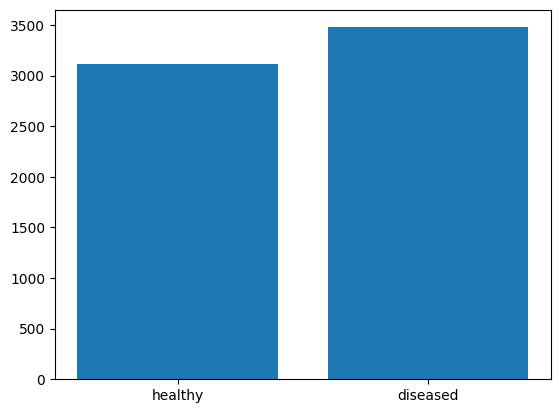

In [24]:
import matplotlib.pyplot as plt

labels_path = f"{NEW_DS_NAME}/train/labels"
label_files = [f for f in os.listdir(labels_path) if f.endswith('.txt')]
num_classes = 2
distribution = [0 for _ in range(num_classes)]

for label_file in label_files:
    label_path = os.path.join(labels_path, label_file)
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        if line.strip():
            class_id = int(line.split()[0])
            distribution[class_id] += 1

plt.plot()
plt.bar(['healthy', 'diseased'], distribution)
plt.show()

In [25]:
model = YOLO("yolov8n.pt")  # or "yolov8n.pt", "yolov8s.pt", "yolov8l.pt", "yolov8x.pt"

model.train(
    data=f'{NEW_DS_NAME}/data.yaml',
    epochs=60,
    imgsz=640,
    batch=16,
    device=0,
    workers=2,
    project='runs/detect',
    name='binary'
)

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=plant_binary/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=binary, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pre

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)
Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CON

train: Scanning /content/plant_binary/train/labels... 1926 images, 8 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 1926/1926 2.4Kit/s 0.8s
train: New cache created: /content/plant_binary/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 301.4±34.8 MB/s, size: 43.5 KB)
val: Scanning /content/plant_binary/valid/labels... 513 images, 3 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 513/513 942.7it/s 0.5s
val: New cache created: /content/plant_binary/valid/labels.cache
Plotting labels to /content/runs/detect/binary/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weig

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       1/60      2.44G      1.395       2.29      1.572         48        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 33.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.2it/s 5.3s
                   all        513       1731      0.428      0.337      0.297      0.152

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       2/60      2.44G      1.378      1.942      1.505         99        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       2/60      2.44G      1.415      1.932       1.58         42        640: 100% ━━━━━━━━━━━━ 121/121 3.3it/s 36.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.0it/s 5.7s
                   all        513       1731      0.401      0.346      0.307      0.134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       3/60      2.44G      1.478      1.935      1.664         92        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       3/60      2.54G      1.467      1.894      1.629         43        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 31.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.2s
                   all        513       1731        0.4       0.42      0.359      0.191

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       4/60      2.54G      1.368      1.701      1.592         90        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       4/60      2.54G      1.464      1.836      1.634         30        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.5it/s 4.8s
                   all        513       1731      0.396      0.395       0.35       0.18

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       5/60      2.54G      1.464      1.854      1.683         71        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       5/60      2.54G      1.447      1.783      1.613         30        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 32.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.3s
                   all        513       1731      0.501      0.453      0.459      0.255

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       6/60      2.54G      1.345       1.62      1.515        108        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       6/60      2.54G      1.424      1.717      1.586         45        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 32.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.5s
                   all        513       1731      0.506      0.432      0.437      0.249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       7/60      2.54G      1.424      1.606      1.625         83        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       7/60      2.54G      1.389      1.664      1.572         33        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 31.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.3s
                   all        513       1731      0.516      0.468      0.472      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       8/60      2.54G      1.213      1.418      1.484         90        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       8/60      2.54G       1.37      1.641      1.559         46        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 31.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.5it/s 4.9s
                   all        513       1731      0.555      0.466      0.496      0.292

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
       9/60      2.54G      1.417      1.481       1.56         97        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


       9/60      2.54G      1.376        1.6      1.543         27        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 32.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.1s
                   all        513       1731      0.561      0.512      0.532      0.326

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      10/60      2.54G      1.307      1.372       1.55        100        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      10/60      2.54G       1.34      1.527      1.528         23        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.1s
                   all        513       1731      0.492      0.502       0.48      0.296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      11/60      2.54G      1.169      1.481      1.474         62        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      11/60      2.54G      1.337      1.519      1.523         47        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.5s
                   all        513       1731      0.637      0.499       0.55      0.333

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      12/60      2.54G       1.28       1.58      1.518         89        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      12/60      2.54G      1.334      1.497       1.52         57        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 31.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.4s
                   all        513       1731      0.612      0.553      0.598      0.372

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      13/60      2.54G      1.387      1.488      1.497        122        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      13/60      2.54G      1.325      1.482      1.512         32        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 32.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.0s
                   all        513       1731      0.566      0.535      0.569      0.339

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      14/60      2.54G      1.325      1.599       1.52        103        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      14/60      2.54G      1.304      1.404      1.499         39        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 31.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.554      0.543      0.579      0.359

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      15/60      2.54G      1.409      1.435      1.487        162        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      15/60      2.55G      1.304       1.42      1.501         48        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.2s
                   all        513       1731      0.589      0.579      0.608      0.369

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      16/60      2.56G      1.339        1.5      1.548         88        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      16/60      2.57G      1.295      1.413      1.483         67        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731       0.61      0.529      0.566      0.355

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      17/60      2.58G      1.297      1.419      1.428        134        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      17/60      2.58G      1.276      1.398      1.488         20        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.3it/s 4.0s
                   all        513       1731      0.611      0.583      0.618      0.389

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      18/60      2.59G       1.34      1.278      1.444        113        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      18/60       2.6G      1.283      1.361      1.479         29        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 31.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.5s
                   all        513       1731      0.651      0.536      0.604       0.38

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      19/60      2.61G      1.149      1.179      1.424        110        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      19/60      2.62G      1.271      1.361      1.479         46        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 32.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.0s
                   all        513       1731      0.663      0.537      0.608      0.384

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      20/60      2.63G       1.21      1.098      1.373        105        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      20/60      2.63G      1.258      1.355      1.461         21        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.2s
                   all        513       1731      0.644       0.56      0.627      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      21/60      2.65G      1.091      1.201      1.389         79        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      21/60      2.65G       1.27      1.344      1.482         64        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731       0.63      0.525       0.59      0.364

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      22/60      2.65G      1.262      1.197      1.491         92        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      22/60      2.67G      1.251      1.307      1.462         34        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.4s
                   all        513       1731      0.636      0.584      0.636      0.408

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      23/60      2.68G      1.393      1.439      1.527        110        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      23/60      2.69G      1.227      1.279      1.451         21        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 32.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.4s
                   all        513       1731      0.645      0.573       0.63      0.393

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      24/60       2.7G      1.056      1.181      1.447         69        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      24/60       2.7G      1.231      1.265      1.438         36        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 31.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731       0.66      0.577      0.636      0.406

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      25/60      2.72G     0.9509      1.156      1.321         65        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      25/60      2.72G      1.213      1.241      1.446         28        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.1s
                   all        513       1731      0.647      0.587      0.656      0.421

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      26/60      2.72G     0.9861     0.9786      1.273         88        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      26/60      2.73G      1.234      1.243      1.439         42        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.663       0.57      0.651      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      27/60      2.75G      1.155      1.107      1.445         79        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      27/60      2.75G      1.211      1.226      1.421         73        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 31.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.3s
                   all        513       1731      0.682      0.535      0.626      0.402

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      28/60      2.77G      1.353      1.358      1.532        100        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      28/60      2.77G      1.206      1.229      1.428         37        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 31.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.4s
                   all        513       1731      0.661      0.615      0.664      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      29/60      2.79G      1.139      1.061      1.346        125        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      29/60      2.79G      1.205      1.192      1.416         38        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 31.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.8s
                   all        513       1731      0.669      0.575      0.657      0.416

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      30/60      2.79G      1.493      1.415       1.51        132        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      30/60       2.8G      1.204      1.214      1.425         20        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.1it/s 5.5s
                   all        513       1731      0.676      0.607      0.672      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      31/60      2.82G       1.15      1.256      1.354         73        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      31/60      2.82G      1.199      1.187      1.412         26        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.6it/s 4.7s
                   all        513       1731      0.653      0.604       0.67       0.43

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      32/60      2.84G      1.252      1.119       1.46         93        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      32/60      2.84G      1.191      1.176      1.408         42        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.3it/s 3.9s
                   all        513       1731      0.664      0.628      0.691       0.45

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      33/60      2.85G      1.451      1.499      1.502        129        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      33/60      2.86G      1.186      1.145      1.407         43        640: 100% ━━━━━━━━━━━━ 121/121 3.6it/s 33.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.5s
                   all        513       1731      0.645      0.637      0.686      0.444

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      34/60      2.86G      1.136        1.1      1.354        102        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      34/60      2.87G      1.159      1.131      1.392         27        640: 100% ━━━━━━━━━━━━ 121/121 3.1it/s 38.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.4it/s 7.1s
                   all        513       1731      0.608      0.598      0.632      0.409

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      35/60      2.89G      1.195       1.08       1.39        106        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      35/60      2.89G      1.177      1.121      1.396         58        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 32.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.1s
                   all        513       1731      0.687      0.607      0.678      0.445

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      36/60       2.9G      1.178      1.224      1.367        105        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      36/60      2.91G      1.154      1.117      1.389         18        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.1s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.7it/s 4.6s
                   all        513       1731      0.676      0.619      0.688      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      37/60      2.92G      1.255      1.195      1.414        124        640: 0% ──────────── 0/121  0.3s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      37/60      2.92G      1.161      1.112      1.385         44        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.2s
                   all        513       1731      0.674      0.625      0.696       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      38/60      2.93G      1.356      1.495      1.525        118        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      38/60      2.94G       1.15      1.116      1.374         45        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 32.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.3s
                   all        513       1731       0.71       0.59      0.694      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      39/60      2.96G      1.124      1.072      1.363         90        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      39/60      2.96G      1.142      1.092      1.371         32        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 32.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.3s
                   all        513       1731      0.705      0.615      0.693      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      40/60      2.97G      0.967      0.978      1.293         78        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      40/60      2.97G      1.128      1.085      1.368         65        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.9it/s 5.8s
                   all        513       1731        0.7      0.615      0.697      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      41/60      2.99G       1.28      1.058      1.456         97        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      41/60      2.99G      1.158      1.079      1.383         30        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.1s
                   all        513       1731      0.665      0.605      0.679      0.449

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      42/60         3G      1.125      1.028      1.329        105        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      42/60      3.01G      1.133      1.049      1.363         44        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.4s
                   all        513       1731      0.678       0.62      0.692      0.456

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      43/60      3.02G      1.069     0.9661      1.366         72        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      43/60      3.03G      1.151      1.066      1.373         46        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 32.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.4s
                   all        513       1731      0.691      0.603      0.685      0.455

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      44/60      3.04G      1.189     0.9912      1.368        110        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      44/60      3.04G      1.119      1.027       1.35         28        640: 100% ━━━━━━━━━━━━ 121/121 3.8it/s 32.2s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.2s
                   all        513       1731      0.692      0.629      0.696      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      45/60      3.06G      1.152      1.205       1.48         79        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      45/60      3.06G      1.113      1.036      1.351         66        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 32.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.1s
                   all        513       1731      0.702      0.627      0.701      0.466

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      46/60      3.06G     0.9854     0.9797      1.382         70        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      46/60      3.08G      1.111      1.032      1.351         41        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 30.7s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.0it/s 5.6s
                   all        513       1731      0.701      0.622      0.701      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      47/60      3.09G     0.9775      1.066      1.308         88        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      47/60       3.1G      1.095     0.9907      1.333         27        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.4it/s 5.0s
                   all        513       1731      0.727       0.62      0.715       0.48

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      48/60      3.11G      1.207      1.043      1.405         75        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      48/60      3.11G      1.107     0.9986      1.341         26        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.3it/s 4.0s
                   all        513       1731      0.685      0.627      0.703       0.47

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      49/60      3.12G      1.232      1.012      1.304        134        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      49/60      3.13G      1.098      0.991      1.335         26        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 32.4s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.1it/s 4.2s
                   all        513       1731      0.685      0.647      0.716      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      50/60      3.13G       1.05      1.001       1.28        102        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      50/60      3.14G      1.103      1.001       1.34         52        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 32.3s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.8it/s 4.5s
                   all        513       1731      0.713      0.628      0.718      0.476
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      51/60      3.16G      1.358      1.087      1.558         64        640: 0% ──────────── 0/121  0.7s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      51/60      3.16G      1.068      0.914      1.334         14        640: 100% ━━━━━━━━━━━━ 121/121 3.7it/s 33.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.2s
                   all        513       1731      0.695      0.639      0.711      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      52/60      3.18G      1.517      1.278      1.399         96        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      52/60      3.19G      1.045     0.8513      1.318         19        640: 100% ━━━━━━━━━━━━ 121/121 4.1it/s 29.6s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.3it/s 5.2s
                   all        513       1731       0.69       0.63      0.708      0.475

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      53/60       3.2G     0.8181     0.7149      1.184         51        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      53/60       3.2G      1.032     0.8464      1.303         11        640: 100% ━━━━━━━━━━━━ 121/121 4.0it/s 30.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.1s
                   all        513       1731      0.699      0.652      0.716      0.481

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      54/60       3.2G      1.075     0.8194       1.25         55        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      54/60      3.21G      1.031     0.8577      1.307         36        640: 100% ━━━━━━━━━━━━ 121/121 4.0it/s 30.5s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.9it/s 4.3s
                   all        513       1731      0.728      0.636      0.725      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      55/60      3.23G     0.7667     0.5867      1.182         32        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      55/60      3.23G      1.012     0.8236      1.287         17        640: 100% ━━━━━━━━━━━━ 121/121 4.0it/s 29.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.4it/s 5.0s
                   all        513       1731      0.742       0.61       0.72      0.487

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      56/60      3.25G      0.763     0.6582        1.2         37        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      56/60      3.25G      1.004     0.8063      1.282         17        640: 100% ━━━━━━━━━━━━ 121/121 4.0it/s 30.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.3s
                   all        513       1731      0.724      0.633      0.727      0.492

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      57/60      3.26G      1.126     0.9262      1.286         79        640: 0% ──────────── 0/121  0.3s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      57/60      3.27G      1.004     0.8098      1.289         15        640: 100% ━━━━━━━━━━━━ 121/121 3.9it/s 31.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.2s
                   all        513       1731      0.746      0.611      0.718      0.486

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      58/60      3.27G     0.8675     0.7578      1.222         42        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      58/60      3.28G     0.9922     0.7929       1.28         19        640: 100% ━━━━━━━━━━━━ 121/121 4.0it/s 29.9s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 3.2it/s 5.3s
                   all        513       1731       0.73      0.616      0.715      0.488

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      59/60       3.3G     0.9894     0.8159      1.191         53        640: 0% ──────────── 0/121  0.1s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      59/60       3.3G     0.9927     0.7976      1.273         36        640: 100% ━━━━━━━━━━━━ 121/121 4.1it/s 29.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.0it/s 4.3s
                   all        513       1731      0.725      0.614      0.714      0.485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
      60/60      3.31G     0.8652     0.6124      1.225         40        640: 0% ──────────── 0/121  0.2s

Deterministic behavior was enabled with either `torch.use_deterministic_algorithms(True)` or `at::Context::setDeterministicAlgorithms(true)`, but this operation is not deterministic because it uses CuBLAS and you have CUDA >= 10.2. To enable deterministic behavior in this case, you must set an environment variable before running your PyTorch application: CUBLAS_WORKSPACE_CONFIG=:4096:8 or CUBLAS_WORKSPACE_CONFIG=:16:8. For more information, go to https://docs.nvidia.com/cuda/cublas/index.html#results-reproducibility (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:233.)


      60/60      3.32G     0.9787     0.7788      1.273         29        640: 100% ━━━━━━━━━━━━ 121/121 4.1it/s 29.8s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 4.2it/s 4.1s
                   all        513       1731      0.723      0.614      0.715      0.486

60 epochs completed in 0.612 hours.
Optimizer stripped from /content/runs/detect/binary/weights/last.pt, 6.3MB
Optimizer stripped from /content/runs/detect/binary/weights/best.pt, 6.3MB

Validating /content/runs/detect/binary/weights/best.pt...
Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 17/17 2.3it/s 7.2s
                   all        513       1731      0.724      0.632      0.727      0.492
               healthy        179       

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7f3560dcc290>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [26]:
model = YOLO('runs/detect/binary/weights/best.pt')

results = model.val(
    data=f'{NEW_DS_NAME}/data.yaml',
    split='test',
    project='runs/detect',
    name='binary_val'
)

print("Validation results:")
print(f"mAP50: {results.box.map50:.4f}")
print(f"mAP50-95: {results.box.map:.4f}")
print(f"Precision: {results.box.mp:.4f}")
print(f"Recall: {results.box.mr:.4f}")

Ultralytics 8.3.225 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1473.7±428.8 MB/s, size: 54.8 KB)
val: Scanning /content/plant_binary/test/labels... 128 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 128/128 2.4Kit/s 0.1s
val: New cache created: /content/plant_binary/test/labels.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 8/8 2.3it/s 3.5s
                   all        128        486      0.761      0.725      0.802      0.537
               healthy         41        204      0.806      0.765      0.858      0.604
              diseased         88        282      0.716      0.684      0.747      0.471
Speed: 6.3ms preprocess, 4.6ms inference, 0.0ms loss, 3.4ms postprocess per image
Results saved to /content/runs/detect/binary_val
Validation results:
mAP50: 0.8025
mAP

In [27]:
!zip -r binary.zip runs/detect/

  adding: runs/detect/ (stored 0%)
  adding: runs/detect/binary_val/ (stored 0%)
  adding: runs/detect/binary_val/val_batch1_pred.jpg (deflated 5%)
  adding: runs/detect/binary_val/val_batch0_labels.jpg (deflated 6%)
  adding: runs/detect/binary_val/val_batch1_labels.jpg (deflated 6%)
  adding: runs/detect/binary_val/BoxPR_curve.png (deflated 13%)
  adding: runs/detect/binary_val/BoxR_curve.png (deflated 12%)
  adding: runs/detect/binary_val/val_batch2_pred.jpg (deflated 5%)
  adding: runs/detect/binary_val/confusion_matrix_normalized.png (deflated 29%)
  adding: runs/detect/binary_val/BoxF1_curve.png (deflated 12%)
  adding: runs/detect/binary_val/confusion_matrix.png (deflated 31%)
  adding: runs/detect/binary_val/val_batch0_pred.jpg (deflated 6%)
  adding: runs/detect/binary_val/val_batch2_labels.jpg (deflated 6%)
  adding: runs/detect/binary_val/BoxP_curve.png (deflated 12%)
  adding: runs/detect/val/ (stored 0%)
  adding: runs/detect/val/val_batch1_pred.jpg (deflated 5%)
  adding:

### Desease detection pipeline

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.



image 1/1 /content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG: 640x640 1 diseased, 9.4ms
Speed: 2.4ms preprocess, 9.4ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 640)
6 0.3737746775150299
It's healthy, YOLO is mistaken


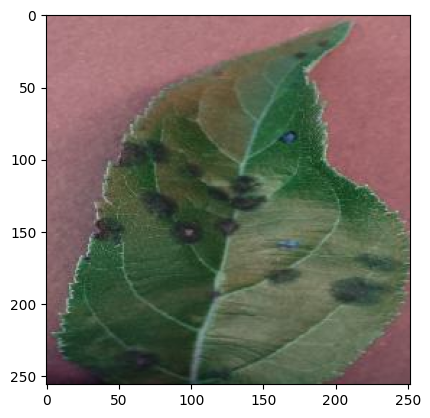

In [55]:
from ultralytics import YOLO
import torch
import torch.nn as nn
from torchvision import models, transforms
import cv2
import numpy as np

class_names = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy',
              'Blueberry___healthy',
              'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy',
              'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy',
              'Orange___Haunglongbing_(Citrus_greening)',
              'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy',
              'Raspberry___healthy',
              'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy',
              'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

class DiseaseDetectionPipeline:
    def __init__(self, detection_model_path, classification_model_path, num_classes):
        self.detection_model = YOLO(detection_model_path)

        # Load classification model
        self.classification_model = models.efficientnet_b3(pretrained=False)

        # Fix the model architecture - you had a typo here
        num_ftrs = self.classification_model.classifier[1].in_features
        self.classification_model.classifier[1] = nn.Linear(num_ftrs, num_classes)
        self.classification_model.load_state_dict(torch.load(classification_model_path, map_location='cpu'))
        self.classification_model.eval()

        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize((300, 300)),  # EfficientNet-B3 uses 300x300
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                               std=[0.229, 0.224, 0.225])
        ])

        self.class_names = class_names
        self.healthy_class_indices = self._get_healthy_indices()

    def _get_healthy_indices(self):
        """Get indices of all healthy classes"""
        healthy_indices = []
        for i, name in enumerate(self.class_names):
            if 'healthy' in name.lower():
                healthy_indices.append(i)
        return healthy_indices

    def predict(self, image_path, confidence_threshold=0.5):
        detection_results = self.detection_model(image_path, conf=confidence_threshold)

        detections = []
        for result in detection_results:
            if result.boxes is not None:
                for box in result.boxes:
                    # Get bounding box coordinates and class
                    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy()
                    conf = box.conf[0].cpu().numpy()
                    cls = int(box.cls[0].cpu().numpy())  # Get detection class

                    # Get class name from detection model
                    detection_class_name = self.detection_model.names[cls]

                    # Only process if YOLO detects as diseased
                    if 'diseased' in detection_class_name.lower():
                        # Step 2: Crop detected region
                        image = cv2.imread(image_path)
                        cropped = image[int(y1):int(y2), int(x1):int(x2)]

                        plt.imshow(cropped)

                        if cropped.size > 0:
                            # Step 3: EffiNet classification on cropped region
                            disease_class, disease_conf = self.classify_disease(cropped)

                            print(disease_class, disease_conf)

                            # Filter out healthy results from EfficientNet
                            if disease_class not in self.healthy_class_indices:
                                detections.append({
                                    'bbox': [x1, y1, x2, y2],
                                    'detection_confidence': conf,
                                    'disease_class': disease_class,
                                    'disease_confidence': disease_conf,
                                    'class_name': self.class_names[disease_class],
                                    'detection_class': detection_class_name
                                })
                            else:
                              print("It's healthy, YOLO is mistaken")

        return detections

    def classify_disease(self, cropped_image):
        input_tensor = self.transform(cropped_image).unsqueeze(0)

        with torch.no_grad():
            outputs = self.classification_model(input_tensor)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidence, predicted = torch.max(probabilities, 1)

        return predicted.item(), confidence.item()

# Initialize pipeline
pipeline = DiseaseDetectionPipeline(
    detection_model_path='runs/detect/binary/weights/best.pt',
    classification_model_path='best_efficientnet_model.pth',
    num_classes=len(class_names)
)

# Test
results = pipeline.predict('/content/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG')
for result in results:
      print(f"Disease: {result['class_name']} "
            f"(Disease Confidence: {result['disease_confidence']:.2f}) "
            f"at location {result['bbox']}")